In [119]:
import numpy as np
from importlib import reload
from scipy import signal

import plotting_tools as pt
import utils
import dsi
utils = reload(utils)
pt = reload(pt)
dsi = reload(dsi)

import pickle
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

In [120]:
Nx, Ny, Nz = 64, 1, 64
et = 1.0

def load(Nx,Ny,et):
    base_fn = 'output_swe_vortex'
    pydir = '../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
    tags = tc.get_tag_dict()
    
    return tc, tags
tc, tags = load(Nx,Ny,et)

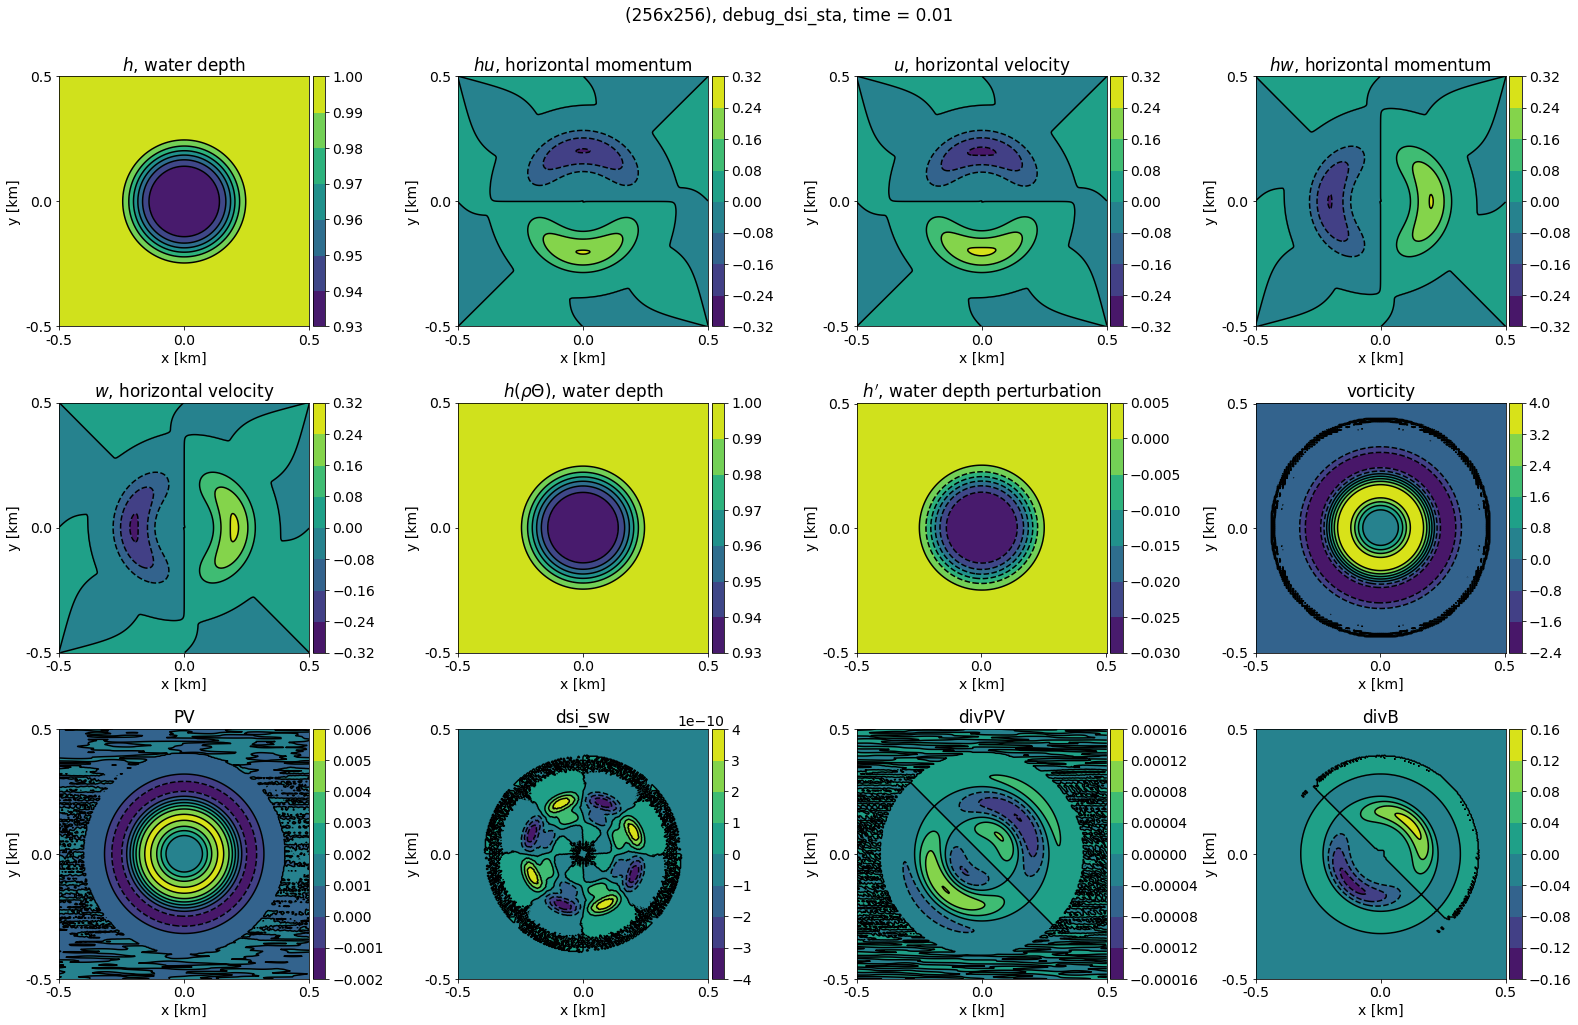

In [116]:
N = 1
sfx0 = 'f_comp_bal_ib-0'
sfx0 = 'f_psinc_imbal'
sfx0 = 'debug_dsi_sta'

sfx = sfx0

fn_pickle = tc.get_filename(N,sfx0,format='dat')
path_pickle = tc.get_path(fn_pickle)
fn = tc.get_filename(N,sfx)
path = tc.get_path(fn)

attributes = ['rho','rhou','rhow','rhoY','p2_nodes','vorty']
t_lbl = 'TIME'
slc = 0

times = np.arange(0,1.0+0.01,0.01)
tag = tags[9]
plot_lbls = pt.lake_labels()
plot_lbls = pt.swe_labels()

# load pickled data
file = open(path_pickle,'rb')
ud = pickle.load(file)
elem = pickle.load(file)
node = pickle.load(file)
file.close()

dx = np.diff(elem.x)[0] * ud.h_ref
dy = np.diff(elem.z)[0] * ud.h_ref

class oo(object): pass
data = oo()

g = 9.81
# g = ud.g0

debug = True
if debug == True: arr_lst = []
time_series = np.zeros((times.shape[0],len(attributes)+6,2), dtype='object')

for tt,time in enumerate(times):
    tag = 'ic' if tt == 0 else tags[9]
    plt_cnt = 0
    for atr_idx, attribute in enumerate(attributes):
        arr = tc.get_arr(path, time, N, attribute, label_type=t_lbl, tag=tag, inner=True, avg=False)[0][:,slc,:]
        arr = arr.T
        arr0 = np.copy(arr)
        
        setattr(data,attribute,arr)
        
        arr = [arr, plot_lbls[attribute]]
        time_series[tt,plt_cnt] = arr
        plt_cnt += 1
        if attribute == 'rhou' or attribute == 'rhow':
            arr0 /= data.rho
            attribute = attribute[-1]
#             arr0 = [arr0, r'$%s^{(0)}$' %attribute]
            arr0 = [arr0, r'$%s$, horizontal velocity' %attribute]
            time_series[tt,plt_cnt] = arr0
#             print(attribute,plt_cnt)
            plt_cnt += 1
        
    # Calculate DSI_SW
    dsi_sw, PV, B = dsi.get_DSI_SW(data, g, ud, elem)
    divPV = dsi.grad(PV,dx,'x') + dsi.grad(PV,dy,'y')
    divB = dsi.grad(B,dx,'x') + dsi.grad(B,dy,'y')
    PV = [PV, 'PV']
    dsi_sw = [dsi_sw,'dsi_sw']
    
    divPV = [divPV, 'divPV']
    divB = [divB, 'divB']
    
    time_series[tt,plt_cnt] = PV
    time_series[tt,plt_cnt+1] = dsi_sw
    time_series[tt,plt_cnt+2] = divPV
    time_series[tt,plt_cnt+3] = divB

if debug == True:
    idx = 1
    fs = (22,5.5)
    fs = (22,15)
#     fs = (22,22)
    # fs = (6,6)
    ncolslen = int((len(attributes))/2) if len(attributes) > 1 else 1
    ncolslen = 4
    pl = pt.plotter(time_series[idx],ncols=ncolslen,figsize=fs,sharey=False)

    x_axs = [-0.5,0.0,0.5]
    y_axs = [-0.5,0.0,0.5]
    x_loc = np.linspace(0,Nx-1,3)
    y_loc = np.linspace(0,Nz-1,3)
    lvls = [None] * 12
    
#     lvls[0] = np.arange(0.98,1.01,0.01)
#     lvls[3] = lvls[0]
    
    x_label = r'x [km]'
    y_label = r'y [km]'
    st = 'SWE shear flow (%ix%i), $\Delta t = 12s$. Potential vortcity in the (x-z) plane.' %(Nx,Nz)
    st = '(%ix%i), %s, time = %.2f' %(Nx,Nz, sfx, times[idx])

    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
    _ = pl.plot(aspect='equal',method='contour',suptitle=st, lvls=lvls)
    pl.save_fig('./output/swetv_%.2f' %(times[idx]))

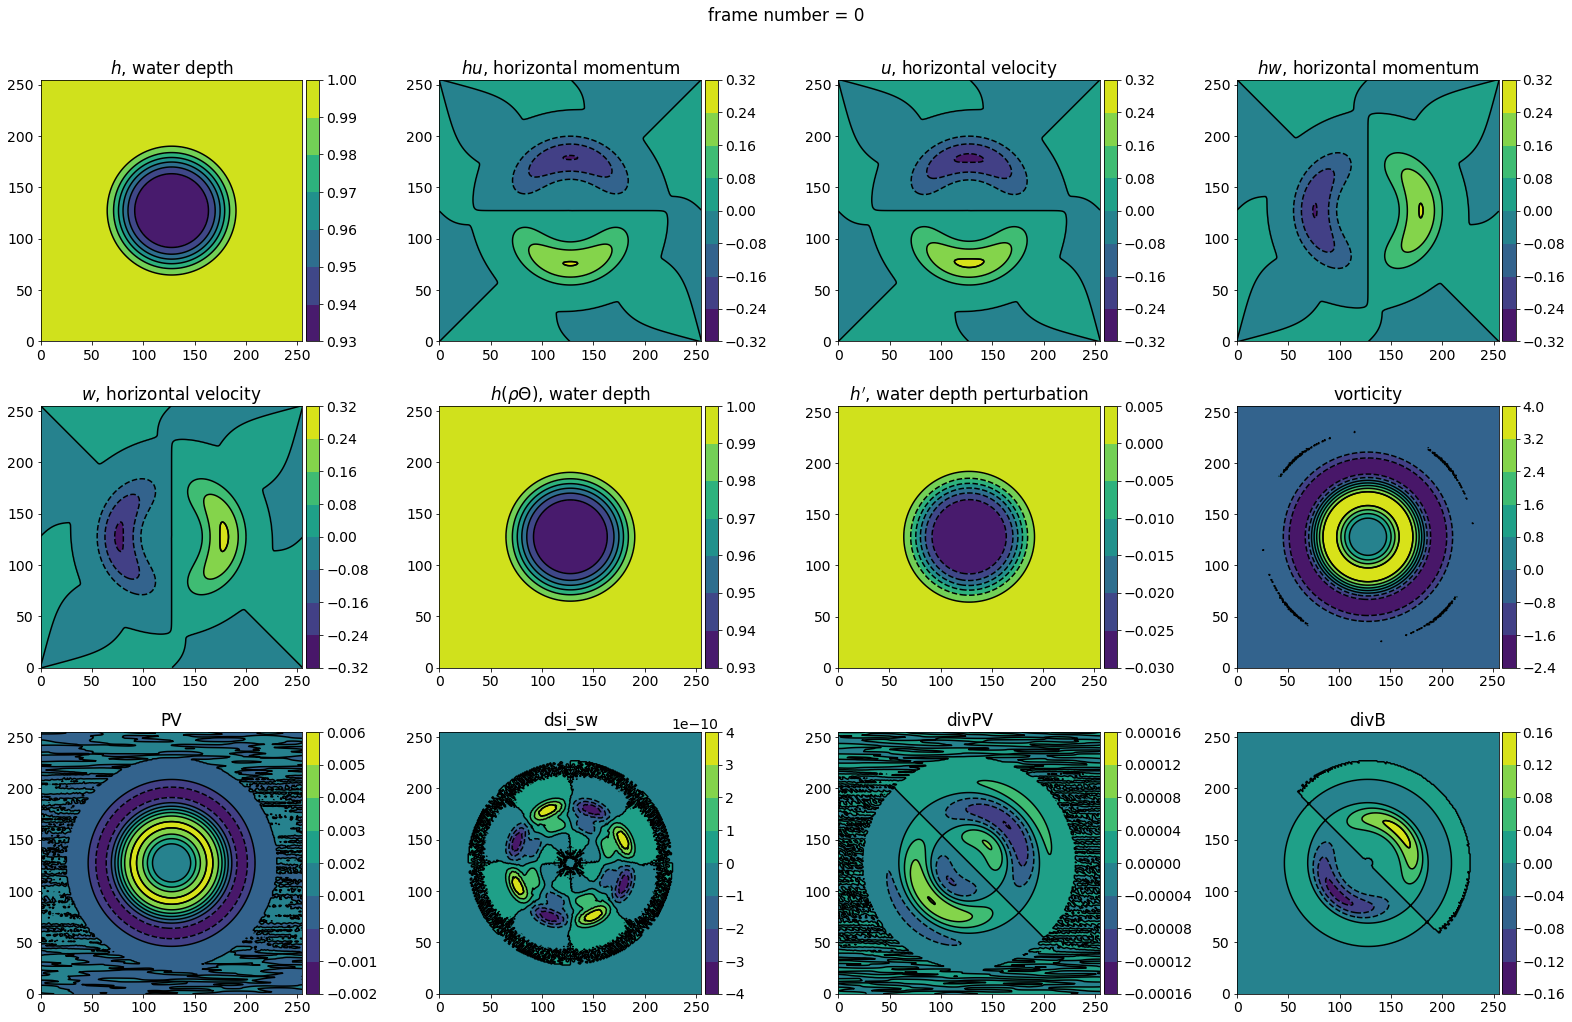

In [117]:
import plotting_tools as pt
pt = reload(pt)

def title_gen(frn):
    return "frame number = %i" %frn

fs = (22,15)
a2d = pt.animator_2D(time_series,ncols=4,figsize=fs)
a2d.suptitle = title_gen
a2d.method = 'contour'
anim = a2d.animate(interval=500, aspect='equal', method='contour', lvls=lvls)

In [118]:
import matplotlib.animation as animation

Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Ray Chew'), bitrate=6000)
anim.save('./output/%i_%i_bal_vortex_%s.mp4' %(Nx,Nz,sfx), writer=writer)